In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
from sklearn_crfsuite import metrics
random.seed(1024)
import torchtext.vocab as vocab
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import time
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [ ]:
def readfile(filename):
    '''
    read file
    
    return format : [[word,NER-tag],[word,NER-tag],[word,NER-tag]..........]
    Example:
            [ [('EU', 'B-ORG\n'),
          ('rejects', 'O\n'),
          ('German', 'B-MISC\n'),
          ('call', 'O\n'),
          ('to', 'O\n'),
          ('boycott', 'O\n'),
          ('British', 'B-MISC\n'),
          ('lamb', 'O\n'),
          ('.', 'O\n')], ]
    '''
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append((splits[0],splits[-1]))

    if len(sentence) >0:
        sentences.append(sentence)
        sentence = []
    return sentences

In [ ]:
'''Segregate words and tags and find count of each tag(each tag being a class)
words = ['EU','rejects','German','call','to','boycott','British','lamb'..................]
tags = ['B-ORG\n', 'O\n','B-MISC\n','O\n','O\n','O\n','B-MISC\n','O\n','O\n','B-PER\n'...]
'''

tag_counts = {}
words = []
tags = []
for word in flatten(readfile('train.txt')):
    words.append(word[0])
    tags.append(word[1])
    tag_counts[word[1]] = tag_counts.get(word[1], 0) + 1

In [ ]:
tag_counts

In [ ]:
# dataset_length = 10
# epoch_length = 100 # each epoch sees 100 draws of samples
# sample_probabilities = torch.randn(23623)
# weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_probabilities, epoch_length)
# torch.utils.data.DataLoader(...., sampler=weighted_sampler)

In [ ]:
# prob = 1/sampler # probability of class 1 = 0.7, of 2 = 0.3 etc
# # class[i] = list containing class present at index i in the dataset  
# for index in 23623:
#     reciprocal_weights[index] = prob[class[index]]

# weights = (1 / torch.Tensor(reciprocal_weights))
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(dataset))

In [ ]:
tagset=list(set(tags))
vocab = set(words)
len(vocab)

In [ ]:
'''Populate word2index to index each word
word2index = {'<UNK>': 0,'<PAD>': 1,'chosed': 2,'prized': 3,'coconut': 4,'11': 5,'3.65': 6,'myth': 7,'McKinney': 8,'1948-52': 9 .... }

'''

word2index={'<UNK>' : 0,'<PAD>':1} # dummy token is for start or end of sentence
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
index2word = {v:k for k, v in word2index.items()}

len(word2index)

In [ ]:
'''Populate tag2index to index each tag (or class).
In the cells further from here, we'd treat each word's NER tag as a class'''

tag2index = {'PAD':0}
for tag in tagset:
    if tag2index.get(tag) is None:
        tag2index[tag] = len(tag2index)
index2tag={v:k for k, v in tag2index.items()}
tag2index

In [ ]:
'''View data'''

data = []
for sent in readfile('train.txt'):
    words,tags=list(zip(*sent))
    data.append([words,tags])
data[0][0]

In [ ]:
'''Form sentence windows

input sentence = ('EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.')

output_windows = 

('<PAD>', '<PAD>', '<PAD>', 'EU', 'rejects', 'German', 'call', 'to', 'boycott'), 
('<PAD>', '<PAD>', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British'),
 ('<PAD>', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb'),
 ('EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'), 
('rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.', '<PAD>'), 
('German', 'call', 'to', 'boycott', 'British', 'lamb', '.', '<PAD>', '<PAD>'), 
('call', 'to', 'boycott', 'British', 'lamb', '.', '<PAD>', '<PAD>', '<PAD>'), 
('to', 'boycott', 'British', 'lamb', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>')]

THE MODEL CONVOLVES OVER EACH WINDOW AS AN INDIVIDUAL IMAGE POST EMBEDDING.
AREA of Improvement: Choice of the best embedding scheme. Currently it only uses the default embeddings available with PyTorch'''

WINDOW_SIZE = 4
windows = []
for sample in data:
    dummy = ['<PAD>'] * WINDOW_SIZE
    window_sent = list(nltk.ngrams(dummy + list(sample[0]) + dummy, WINDOW_SIZE * 2 + 1))
    window_tag = list(nltk.ngrams(['PAD']*WINDOW_SIZE + list(sample[1]) + ['PAD']*WINDOW_SIZE, WINDOW_SIZE * 2 + 1))
    tag_counts['PAD'] = tag_counts.get('PAD', 0) + 2*WINDOW_SIZE
    windows.extend([[list(window_sent[i]), list(window_tag[i])] for i in range(len(sample[0]))])
len(windows)

In [ ]:
'''Get class size by indices'''

indexed_counts = {}
for key in tag2index.keys():
    indexed_counts[tag2index[key]] = tag_counts[key]
    

In [ ]:
indexed_counts

In [ ]:
tag_counts

In [ ]:
'''Calculate class weights and populate into a list named sampler in order of the class indices'''

tag_weights = {}
for key in indexed_counts.keys():
    tag_weights[key] = 1/indexed_counts[key]
sampler = [i[1] for i in sorted(tag_weights.items())]

In [ ]:
sampler

In [ ]:
'''Compare the order of class weights to make sure that the class weights are fed in an order that the CrossEntropyLoss() function would expect'''
print(sampler,'\n',tag_weights)

In [ ]:
'''Format inputs to be fed into model'''

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(torch.Tensor(idxs)).long().cuda()

def prepare_word(word, word2index):
    return Variable(torch.Tensor([word2index[word]]) if word2index.get(word) is not None else torch.tensor([word2index["<UNK>"]],dtype=torch.long)).cuda()

# def prepare_tag(tag,tag2index):
#     return Variable(torch.Tensor(np.array(tag2index[tag]))).long().cuda()

def prepare_tag(tag,tag2index):
    idxs = list(map(lambda t: tag2index[t], tag))
    return Variable(torch.Tensor(idxs)).long().cuda()

In [ ]:
'''Shuffle and split data into test  and train'''
# random.shuffle(windows)
test_data = windows[int(len(windows)*0.9):]
train_data = windows[:int(len(windows)*0.9)]
len(train_data)

In [ ]:
'''Create batch generator'''

def getBatch(batch_size, train_data):
    #random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

# Data size transitions

inputs torch.Size([128, 1, 9, 50])

post cnn1 torch.Size([128, 120, 3, 1])
post maxpool3 torch.Size([128, 120, 1])

post cnn2 torch.Size([128, 120, 4, 1])
post maxpool4 torch.Size([128, 120, 1])

post cnn3 torch.Size([128, 120, 5, 1])
post maxpool5 torch.Size([128, 120, 1])

concatenated (cnn1 + cnn2 + cnn3) data: torch.Size([128, 360, 1])

output post linear layer torch.Size([128, 10, 9])

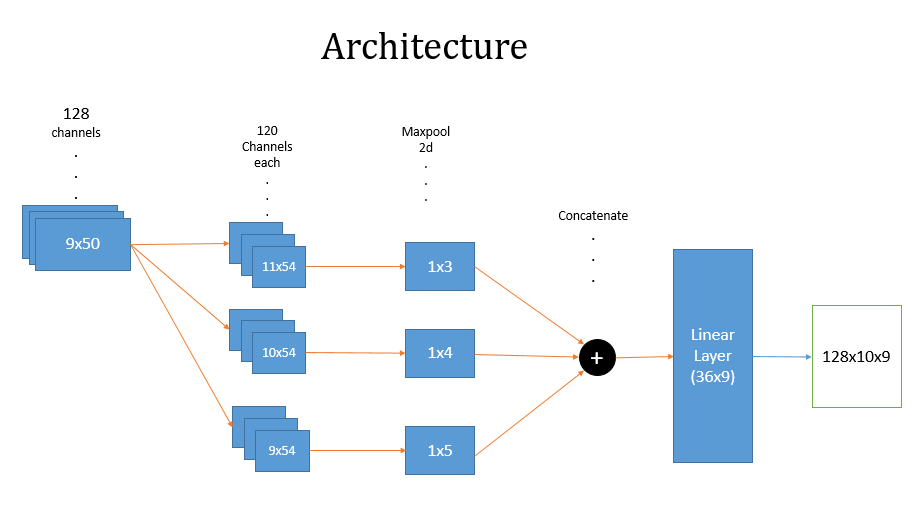

In [ ]:
'''The Model Definiton'''

class CNN_NER(nn.Module): 
    def __init__(self,vocab_size,embedding_size):
        # vocab_size, embedding_size, window_size, hidden_size, output_size

        super(CNN_NER, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.cnn1 = nn.Conv2d(in_channels=1,padding=2,out_channels=120,kernel_size=(11,54),stride=1,dilation=1)
        self.cnn2 = nn.Conv2d(in_channels=1,padding=2,out_channels=120,kernel_size=(10,54),stride=1,dilation=1)
        self.cnn3 = nn.Conv2d(in_channels=1,padding=2,out_channels=120,kernel_size=(9,54),stride=1,dilation=1)
        
        self.relu = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1,3))
        self.maxpool4 = nn.MaxPool2d(kernel_size=(1,4))
        self.maxpool5 = nn.MaxPool2d(kernel_size=(1,5))
        self.linear = nn.Linear(36,9)
        self.softmax = nn.LogSoftmax()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,sent_grams,is_training):
        embeds = self.embed(sent_grams)
        embeds = embeds.unsqueeze(1)
        #print('inputs',embeds.size())
        
        l1 = self.cnn1(embeds)
        l1 = self.relu(l1)
        if is_training:
            l1 = self.dropout(l1)
        #print('cnn1',l1.size())
        l1 = l1.squeeze(3)
        l1 = self.maxpool3(l1)
        #print('maxpool3',l1.size())
        
        l2 = self.cnn2(embeds)
        l2 = self.relu(l2)
        if is_training:
            l2 = self.dropout(l2)
        #print('cnn2',l2.size())
        l2 = l2.squeeze(3)
        l2 = self.maxpool4(l2)
        #print('maxpool4',l2.size())
        
        l3 = self.cnn3(embeds)
        l3 = self.relu(l3)
        if is_training:
            l3 = self.dropout(l3)
        #print('cnn3',l3.size())
        l3 = l3.squeeze(3)
        l3 = self.maxpool5(l3)
        #print('maxpool5',l3.size())
        
        l4 = torch.cat((l1,l2,l3),1)
        if is_training:
            l4 = self.dropout(l4)
        #print('concatenated',l4.size())
        l4 = l4.view(l4.size(0),10,36)
        #print('quished before linear layer',l4.size())
        l5 = self.linear(l4)
        #print('output',l5.size())
        l5 = self.softmax(l5)
        return l5
        

In [ ]:
'''Hyper-parameters'''

BATCH_SIZE = 128
EMBEDDING_SIZE = 50 # x (WINDOW_SIZE*2+1) = 250
# HIDDEN_SIZE = 300
# Test accuracy decreases after 5 epochs
EPOCH = 15
LEARNING_RATE = 0.003
model = CNN_NER(len(word2index), EMBEDDING_SIZE)
model.cuda()
# Visualize the model paramters
for name,params in model.named_parameters():
    if params.requires_grad:
        print(name,params.data.size())

In [ ]:
'''define loss and optimizer
ignore_index=word2index['<PAD>'] should only be used when the ignored class exists rarely in the input. Hence, we pass the class weights instead

Area of Improvement: Addressing class imbalance in some way. Most word tags are O\n and the model only learns this tag well.'''

loss_function = nn.CrossEntropyLoss(weight = torch.Tensor(sampler)).cuda()
#loss_function = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
len(tag2index)

In [ ]:
'''Train and Validate'''

# There is a bug in here that, causes the loop counter to be printed twice. Kindly ignore for now.
# 15 epochs actually means 30 epochs here.

now = time.time()

# TRAIN

for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        
        x,y=list(zip(*batch))
        if len(x) == 128:
            inputs = torch.cat([prepare_sequence(sent, word2index).view(1, -1) for sent in x])
            targets = torch.cat([prepare_tag(tag, tag2index).view(1,-1) for tag in y])
            #print('input size',inputs.size())
            #print('target size',targets.size())
            model.zero_grad()
            preds = model(inputs, is_training=True)
            #print('preds,targets before loss',preds.size(),targets.size())
            loss = loss_function(preds, targets)
            #print(loss.item())
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
            # VALIDATE
            
            #print(loss)
            if i % 1000 == 0:
                model.eval()
                total = 0.0
                correct = 0.0
                #Testing
                for i,batch in enumerate(getBatch(128, test_data)):
                    x,y=list(zip(*batch))
                    inputs = torch.cat([prepare_sequence(sent, word2index).view(1, -1) for sent in x])
                    targets = torch.cat([prepare_tag(tag, tag2index).view(1,-1) for tag in y])
                    model.zero_grad()
                    preds = model(inputs, is_training=False)
                    out = torch.max(preds,1)[1]
                    total += targets.size(0)*targets.size(1)
                    correct += (out.cpu()==targets.cpu()).sum()
                    acc = correct.double()/total * 100
                print("[%d/%d] mean_loss : %0.2f accuracy : %0.2f" %(epoch, EPOCH, np.mean(losses),acc))
                losses = []
            model.train()
print('time taken in seconds: {} seconds'.format(time.time()-now)) 

In [ ]:
''' Evaluate model on a custom sentence
Returns: predicted class indices like so:

[[8 4 4 4 4 4 8 4 4]]

'''

sent = input('Enter a sentence: ')
seq = sent.split(' ')
# seq2 = [seq for x in range(128)]
# seq = seq*128
print(seq)
indices = prepare_sequence(seq,word2index)
print(indices)
indices.unsqueeze_(0)
# print(indices.size())
# Germany lost a soccer game to Spain on Tuesday
model.eval()
preds = model(indices,True)
model.train()

print(preds)
final_preds = torch.max(preds,1)[1].cpu().numpy()
print(final_preds)


In [ ]:
'''Convert class indices to tags for better readability'''

for preds in final_preds:
    print([index2tag[pred] for pred in preds])

In [ ]:
'''Code cells from here on, evaluate the F1 score of the model'''

ytest = []
for test in test_data:
    #print('sent',test[0],'\n label',test[1])
    ytest.append(test[1])
list(ytest)

In [ ]:
for_f1_score = []
accuracy = 0
for test in test_data:
    x, y = test[0], test[1]
    input_ = prepare_sequence(x, word2index).view(1, -1)

    i = model(input_,False).max(1)[1]
    #print([index2tag[ind] for ind in i.data.tolist()[0]])
    pred = [index2tag[ind] for ind in i.data.tolist()[0]]
    for_f1_score.append([pred, y])
    if pred == y:
        accuracy += 1

print(accuracy/len(test_data) * 100)

In [ ]:
ypred,ytest = list(zip(*for_f1_score))

In [ ]:
print(metrics.flat_classification_report(list(ytest), list(ypred), labels=sorted(tagset), digits=3))

## Double tap for  better readability

###                      precision  recall    f1-score    support

         B-LOC
          0.789     0.809     0.799      4196

        B-MISC
          0.733     0.741     0.737      2026

         B-ORG
          0.590     0.480     0.529      2929

         B-PER
          0.635     0.756     0.690      2472

         I-LOC
          0.894     0.610     0.725      1023

        I-MISC
          0.544     0.382     0.449       468

         I-ORG
          0.788     0.528     0.632      3271

         I-PER
          0.854     0.651     0.739      1543

             O
          0.971     0.983     0.977    143315

    avg / total      0.945     0.947     0.945    161243


In [ ]:
'''Save the state_dict of the model. The best model by far has been saved to the local drive.
Please feel free to play around!
Further improvement model/weights initialization'''

torch.save(model.state_dict(),'CNN_NER_checkpoint1.pth')

In [ ]:
torch.cuda.is_available()